# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf
from scipy.stats import ks_2samp
from sklearn import metrics

In [70]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital)
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

**Verificando e identificando valores faltantes, duplicados ou incorretos:**

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


In [72]:
df.isna().sum()

age            0
sex            0
cp             0
trestbps       0
chol           0
fbs            0
restecg        0
thalach        0
exang          0
oldpeak        0
slope          0
ca             0
thal           0
num            0
flag_doente    0
dtype: int64

In [73]:
df.duplicated().value_counts()

False    303
Name: count, dtype: int64

**<br>Valor "?" encontrado na base de dados.**

In [74]:
df[['ca', 'thal']].value_counts()

ca   thal
0.0  3.0     115
     7.0      51
1.0  7.0      32
     3.0      29
2.0  7.0      20
     3.0      14
3.0  7.0      12
0.0  6.0       8
3.0  3.0       6
1.0  6.0       4
2.0  6.0       4
0.0  ?         2
3.0  6.0       2
?    3.0       2
     7.0       2
Name: count, dtype: int64

**<br>Localizando e eliminando linhas com os valores "?":**

In [75]:
value_df = df == "?"
value_df.value_counts()

age    sex    cp     trestbps  chol   fbs    restecg  thalach  exang  oldpeak  slope  ca     thal   num    flag_doente
False  False  False  False     False  False  False    False    False  False    False  False  False  False  False          297
                                                                                      True   False  False  False            4
                                                                                      False  True   False  False            2
Name: count, dtype: int64

In [76]:
value_ca = df['ca'] == "?"
df[value_ca]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1,1
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0,0


In [77]:
value_thal = df['thal'] == "?"
df[value_thal]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0,0
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2,1


In [78]:
value_df = df != "?"
df = df[value_df]
df.isna().sum()

age            0
sex            0
cp             0
trestbps       0
chol           0
fbs            0
restecg        0
thalach        0
exang          0
oldpeak        0
slope          0
ca             4
thal           2
num            0
flag_doente    0
dtype: int64

In [79]:
df.dropna(inplace = True)
df = df.reset_index(drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          297 non-null    float64
 1   sex          297 non-null    float64
 2   cp           297 non-null    float64
 3   trestbps     297 non-null    float64
 4   chol         297 non-null    float64
 5   fbs          297 non-null    float64
 6   restecg      297 non-null    float64
 7   thalach      297 non-null    float64
 8   exang        297 non-null    float64
 9   oldpeak      297 non-null    float64
 10  slope        297 non-null    float64
 11  ca           297 non-null    object 
 12  thal         297 non-null    object 
 13  num          297 non-null    int64  
 14  flag_doente  297 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 34.9+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [80]:
def analise_bivariada(data:pd.DataFrame, x:str, y:str) -> pd.DataFrame:
    ct = pd.crosstab(data[x], data[y], margins=True, margins_name='total')
    ct['odds'] = ct[1] / ct[0]
    ct['logito'] = np.log(ct['odds'])
    ct['odds_ratio'] = ct['odds'] / ct.loc['total', 'odds']
    ct['weight of evidence'] = np.log(ct['odds'] / ct.loc['total', 'odds'])
    ct['probabilidade'] = ct[1] / ct['total']
    return ct

<br>
- sex: sexo (1 = male/másculino; 0 = female/feminino)<br>
- flag_doente: classificação para doença (1 = doente/sick; 0 = saudável/healthy)

In [81]:
analise_bivariada(data=df, x='sex', y='flag_doente')

flag_doente,0,1,total,odds,logito,odds_ratio,weight of evidence,probabilidade
sex,,,,,,,,
0.0,71,25,96,0.352113,-1.043804,0.411226,-0.888611,0.260417
1.0,89,112,201,1.258427,0.229863,1.469696,0.385055,0.557214
total,160,137,297,0.856250,-0.155193,1.000000,0.000000,0.461279


<br>
- exang: angina induzida por exercício(1 = sim; 0 = não)<br>
- flag_doente: classificação para doença (1 = doente/sick; 0 = saudável/healthy)

In [82]:
analise_bivariada(data=df, x='exang', y='flag_doente')

flag_doente,0,1,total,odds,logito,odds_ratio,weight of evidence,probabilidade
exang,,,,,,,,
0.0,137,63,200,0.459854,-0.776846,0.537056,-0.621653,0.315000
1.0,23,74,97,3.217391,1.168571,3.757537,1.323764,0.762887
total,160,137,297,0.856250,-0.155193,1.000000,0.000000,0.461279


<br>
- fbs: açúcar no sangue em jejum > 120 mg/dl (1 = True; 0 = False)<br>
- flag_doente: classificação para doença (1 = doente/sick; 0 = saudável/healthy)

In [83]:
analise_bivariada(data=df, x='fbs', y='flag_doente')

flag_doente,0,1,total,odds,logito,odds_ratio,weight of evidence,probabilidade
fbs,,,,,,,,
0.0,137,117,254,0.854015,-0.157807,0.997389,-0.002614,0.460630
1.0,23,20,43,0.869565,-0.139762,1.015551,0.015431,0.465116
total,160,137,297,0.856250,-0.155193,1.000000,0.000000,0.461279


**A Variável que parece discriminar mais o risco dentre as executadas é ```exang```. A diferença entre os valores de chance/odds, logito, probabilidade permitem separar melhor as possibilidades devido as diferenças das variáveis trazendo melhor compreensão e definição da situação ocorrida.**

2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [84]:
def analise_continuas(data:pd.DataFrame, x:str, y:str, q:int = 5) -> pd.DataFrame:
    sel_5 = pd.qcut(data[x], q=q)
    ct = pd.crosstab(sel_5, data[y], margins=True, margins_name='total')
    ct['odds'] = ct[1] / ct[0]
    ct['logito'] = np.log(ct['odds'])
    ct['odds_ratio'] = ct['odds'] / ct.loc['total', 'odds']
    ct['weight of evidence'] = np.log(ct['odds'] / ct.loc['total', 'odds'])
    ct['probabilidade'] = ct[1] / ct['total']

    #ct['valor médio da faixa'] = df.groupby(sel_5)[x].mean()
    ct['valor médio da faixa'] = df.groupby(sel_5, observed=True)[x].mean()
    ct.loc['total', 'valor médio da faixa'] = df[x].mean()
    ct['valor médio da faixa'] = ct['valor médio da faixa'].round(0)
    return ct

In [85]:
analise_continuas(data=df, x='age', y='flag_doente')

flag_doente,0,1,total,odds,logito,odds_ratio,weight of evidence,probabilidade,valor médio da faixa
age,,,,,,,,,
"(28.999, 45.0]",46,15,61,0.326087,-1.120591,0.380831,-0.965398,0.245902,41.0
"(45.0, 53.0]",40,21,61,0.525000,-0.644357,0.613139,-0.489164,0.344262,50.0
"(53.0, 58.0]",31,39,70,1.258065,0.229574,1.469272,0.384767,0.557143,56.0
"(58.0, 62.8]",13,32,45,2.461538,0.900787,2.874789,1.055979,0.711111,60.0
"(62.8, 77.0]",30,30,60,1.000000,0.000000,1.167883,0.155193,0.500000,67.0
total,160,137,297,0.856250,-0.155193,1.000000,0.000000,0.461279,55.0


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [86]:
regl = smf.logit('''flag_doente ~ 
                     C(sex, Treatment(1)) 
                     + C(cp, Treatment(4))
                     + trestbps 
                     + age''',
                 df).fit()
regl.summary()

Optimization terminated successfully.
         Current function value: 0.480667
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      290
Method:                           MLE   Df Model:                            6
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.3035
Time:                        11:02:31   Log-Likelihood:                -142.76
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 1.910e-24
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -4.0713      1.300     -3.131      0.002      -6.620      -1.522
C(sex, Treatment(1))[T.0.0]    -1.7989      0.352     -5.112      0.000      -2.489      -1.109
C(cp, Treatment(4))[T.1.0]     -2.4547      0.553     -4.443      0.000      -3.538      -1.372
C(cp, Treatment(4))[T.2.0]     -2.4714      0.453     -5.452      0.000      -3.360      -1.583
C(cp, Treatment(4))[T.3.0]     -2.3415      0.362     -6.477      0.000      -3.050      -1.633
trestbps                        0.0192      0.009      2.255      0.024       0.003       0.036
age                             0.0568      0.018      3.110      0.002       0.021       0.093
===============================================================================================
"""

In [87]:
eta_p = (-4.0713)+(0.0192)
chance_p = np.exp(eta_p)
print(f'A razão de chance para doença aumenta: {round(chance_p,3)} para cada unidade de pressão medida(mmHg) na admissão ao hospital.\n')

eta_i = (-4.0713)+(0.0568)
chance_i = np.exp(eta_i)
print(f'A razão de chance para doença aumenta: {round(chance_i,3)} para cada ano de idade.\n')

eta = (-4.0713)+(-1.7989)
chance = np.exp(eta)
prob = 1/(1+np.exp(-eta))
print(f'''O valor para a chance do perfil feminino ficar doente é de: {round(chance, 4)} vezes do que o homem,
já para probabilidade do perfil feminino o valor é de: {round(prob,4)}.\n''')

eta1 = (-4.0713)+(-2.4547)
chance1 = np.exp(eta1)
print(f'A chance do perfil com Angina típica é de: {round(chance1,4)} vezes com relação ao assintomático')
eta2 = (-4.0713)+(-2.4714)
chance2 = np.exp(eta2)
print(f'A chance do perfil com Angina atípica é de: {round(chance2,4)} vezes com relação ao assintomático')
eta3 = (-4.0713)+(-2.3415)
chance3 = np.exp(eta3)
print(f'A chance do perfil com Angina atípica é de: {round(chance3,4)} vezes com relação ao assintomático \n \n')

A razão de chance para doença aumenta: 0.017 para cada unidade de pressão medida(mmHg) na admissão ao hospital.

A razão de chance para doença aumenta: 0.018 para cada ano de idade.

O valor para a chance do perfil feminino ficar doente é de: 0.0028 vezes do que o homem,
já para probabilidade do perfil feminino o valor é de: 0.0028.

A chance do perfil com Angina típica é de: 0.0015 vezes com relação ao assintomático
A chance do perfil com Angina atípica é de: 0.0014 vezes com relação ao assintomático
A chance do perfil com Angina atípica é de: 0.0016 vezes com relação ao assintomático 
 



4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

** Calcule a probabilidade de evento predita segundo o seu modelo:**

In [88]:
# predito_flag valor puro / predito_flag_rounded com valor arredondado para aproximar da flag_doente.
df['predito_flag'] = regl.predict(df)

df['predito_flag_rounded'] = df['predito_flag'].round(0)
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito_flag,predito_flag_rounded
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.458086,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.942756,1.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.884350,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.139590,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.028736,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1,1,0.512804,1.0
293,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1,0.134550,0.0
294,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,1,0.927666,1.0
295,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1,0.840013,1.0


**Categorize essa probabilidade em G=5 grupos:**

In [89]:
predito_ct = pd.qcut(df['predito_flag'], q=5)
group_by = df.groupby(predito_ct, observed=False)['flag_doente'].count()
group_df = pd.DataFrame(group_by)
group_df

,flag_doente
predito_flag,
"(0.0139, 0.149]",61
"(0.149, 0.29]",58
"(0.29, 0.583]",59
"(0.583, 0.819]",61
"(0.819, 0.943]",58


**Calcule a probabilidade de evento predita média por grupo:**

In [90]:
group_df['predito_med'] = df.groupby(predito_ct, observed=False)['predito_flag'].mean()
group_df

,flag_doente,predito_med
predito_flag,,
"(0.0139, 0.149]",61,0.075238
"(0.149, 0.29]",58,0.216382
"(0.29, 0.583]",59,0.440109
"(0.583, 0.819]",61,0.707344
"(0.819, 0.943]",58,0.874928


**Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo:**

In [91]:
group_df['flag_doente_med'] = df.groupby(predito_ct, observed=False)['flag_doente'].mean()
group_df

,flag_doente,predito_med,flag_doente_med
predito_flag,,,
"(0.0139, 0.149]",61,0.075238,0.081967
"(0.149, 0.29]",58,0.216382,0.155172
"(0.29, 0.583]",59,0.440109,0.508475
"(0.583, 0.819]",61,0.707344,0.737705
"(0.819, 0.943]",58,0.874928,0.827586


**Compare graficamente o valor eperado versus observado para a taxa de maus por grupo:**

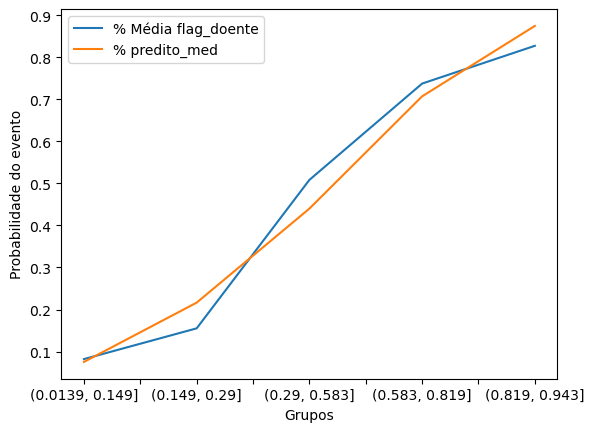

In [92]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax = group_df['flag_doente_med'].plot(label='% Média flag_doente')
ax = group_df['predito_med'].plot(label='% predito_med')


ax.legend()
ax.set_xlabel(xlabel='Grupos')
ax.set_ylabel(ylabel='Probabilidade do evento')

plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [93]:
#Acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito_flag'] > .5)
acc = round(acc*100, 2)

# AUC & GINI
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito_flag'])
auc_ = metrics.auc(fpr, tpr)
gini = 2 * auc_ -1
gini = round(gini*100, 2)

# KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito_flag'], df.loc[df['flag_doente'] != 1, 'predito_flag']).statistic
ks = round(ks*100, 2)

print(f'Acurácia: {acc}%')
print(f'Gini: {gini}%')
print(f'Ks: {ks}%')

Acurácia: 79.12%
Gini: 69.74%
Ks: 58.52%


C:\Users\Guilherme Rhein\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Guilherme Rhein\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Guilherme Rhein\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Guilherme Rhein\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spar

6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [94]:
df.corr().loc[:,'flag_doente'].sort_values()

thalach                -0.423817
fbs                     0.003167
chol                    0.080285
trestbps                0.153490
restecg                 0.166343
age                     0.227075
sex                     0.278467
slope                   0.333049
cp                      0.408945
exang                   0.421355
oldpeak                 0.424052
ca                      0.463189
thal                    0.526640
predito_flag_rounded    0.579585
predito_flag            0.610206
num                     0.829608
flag_doente             1.000000
Name: flag_doente, dtype: float64

In [95]:
reglog = smf.logit('''flag_doente
                            ~ age
                            + C(sex, Treatment(1)) 
                            + C(cp, Treatment(4))
                            + thal
                            + exang
                            + oldpeak
                            ''', df).fit() 
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.395438
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  297
Model:                          Logit   Df Residuals:                      287
Method:                           MLE   Df Model:                            9
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.4270
Time:                        11:02:32   Log-Likelihood:                -117.45
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 5.450e-33
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      -3.4962      1.104     -3.168      0.002      -5.659      -1.333
C(sex, Treatment(1))[T.0.0]    -1.1277      0.418     -2.699      0.007      -1.947      -0.309
C(cp, Treatment(4))[T.1.0]     -2.1125      0.604     -3.497      0.000      -3.297      -0.929
C(cp, Treatment(4))[T.2.0]     -1.2549      0.496     -2.529      0.011      -2.228      -0.282
C(cp, Treatment(4))[T.3.0]     -1.9330      0.426     -4.540      0.000      -2.768      -1.098
thal[T.6.0]                     0.5658      0.673      0.841      0.400      -0.753       1.885
thal[T.7.0]                     1.5468      0.365      4.241      0.000       0.832       2.262
age                             0.0537      0.020      2.732      0.006       0.015       0.092
exang                           0.8368      0.376      2.225      0.026       0.100       1.574
oldpeak                         0.6923      0.181      3.832      0.000       0.338       1.046
===============================================================================================
"""

In [96]:
#Predição
df['predito_flag_improved'] = reglog.predict(df)
#Agrupando
slct = pd.qcut(df['predito_flag_improved'], q=5)
group_by = df.groupby(slct, observed=False)['flag_doente'].count()
group_df = pd.DataFrame(group_by)
#predito médio
group_df['predito_med'] = df.groupby(slct, observed=False)['predito_flag_improved'].mean()
#flag_doente médio
group_df['flag_doente_med'] = df.groupby(slct, observed=False)['flag_doente'].mean()
group_df

,flag_doente,predito_med,flag_doente_med
predito_flag_improved,,,
"(0.0093, 0.0804]",60,0.043772,0.066667
"(0.0804, 0.256]",59,0.156775,0.152542
"(0.256, 0.564]",59,0.400136,0.389831
"(0.564, 0.878]",59,0.760247,0.762712
"(0.878, 0.997]",60,0.944357,0.933333


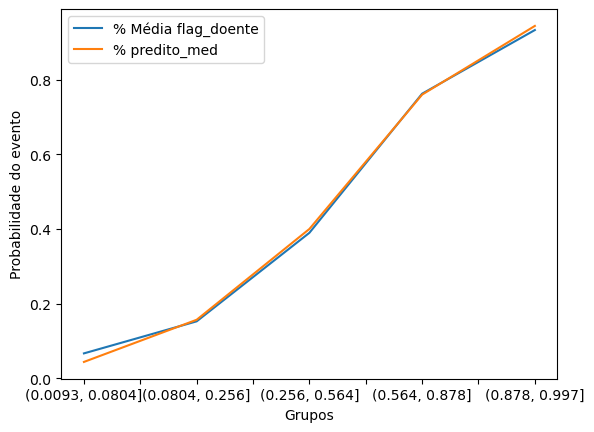

In [97]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax = group_df['flag_doente_med'].plot(label='% Média flag_doente')
ax = group_df['predito_med'].plot(label='% predito_med')


ax.legend()
ax.set_xlabel(xlabel='Grupos')
ax.set_ylabel(ylabel='Probabilidade do evento')

plt.show()

In [98]:
#Acurácia
acc = metrics.accuracy_score(df['flag_doente'], df['predito_flag_improved'] > .5)
acc = round(acc*100, 2)

# AUC & GINI
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito_flag_improved'])
auc_ = metrics.auc(fpr, tpr)
gini = 2 * auc_ -1
gini = round(gini*100, 2)

# KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito_flag_improved'], df.loc[df['flag_doente'] != 1, 'predito_flag_improved']).statistic
ks = round(ks*100, 2)

print(f'Acurácia: {acc}%')
print(f'Gini: {gini}%')
print(f'Ks: {ks}%')

Acurácia: 83.16%
Gini: 79.66%
Ks: 66.12%


C:\Users\Guilherme Rhein\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Guilherme Rhein\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Guilherme Rhein\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Guilherme Rhein\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_spar